In [31]:
import pathlib
from urllib.parse import urlencode

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy.io import fits
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad

# APOGEE data:

You would need to download these files (~3 GB total):
- https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allVisit-dr17-synspec_rev1.fits
- https://users.flatironinstitute.org/~apricewhelan/data/apogee-dr17-binaries/gold-sample.fits

In [90]:
allvisit = at.Table.read('/Users/apricewhelan/data/APOGEE_DR17/allVisitLite-dr17-synspec.fits')
binaries = at.QTable.read(
    'https://users.flatironinstitute.org/~apricewhelan/data/apogee-dr17-binaries/gold-sample.fits'
)

25


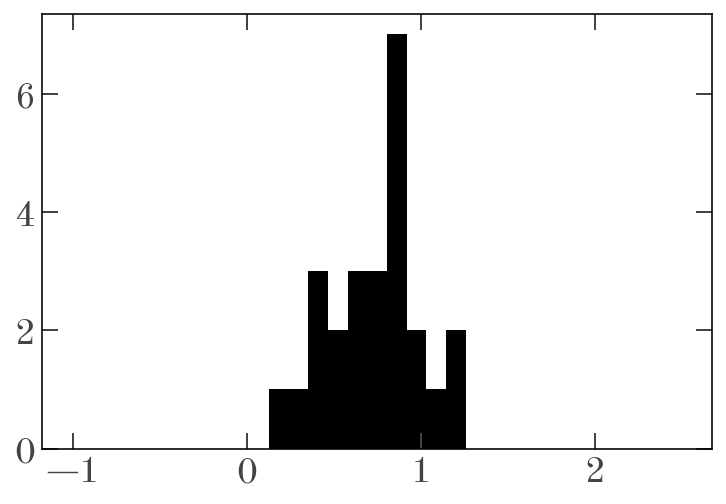

In [251]:
_mask = (
    (binaries['SNR'] > 100) &
    (binaries['MAP_e'] < 0.02) &
    (binaries['LOGG'] > 4.2) &
    (binaries['n_visits'] >= 15) &
    (binaries['MAP_P'] < 20*u.day)
)
print(len(binaries['MAP_P'][_mask].value))

plt.hist(
    np.log10(binaries['MAP_P'][_mask].value),
    bins=np.linspace(-1, 2.5, 32)
);

In [252]:
subset1 = binaries[_mask]
print(len(subset1))

25


In [253]:
good_ids = []
for star in subset1:
    visits = allvisit[allvisit['APOGEE_ID'] == star['APOGEE_ID']]
    visits = visits[(visits['N_COMPONENTS'] == 1) & (visits['SNR'] > 20)]
    if len(visits) >= 12:
        good_ids.append(star['APOGEE_ID'])
        
print(len(good_ids))

subset = binaries[np.isin(binaries['APOGEE_ID'].astype(str), np.array(good_ids))]
len(subset)

14


14

In [267]:
all_visit_subsets = []
for star in subset:
    visits = allvisit[allvisit['APOGEE_ID'] == star['APOGEE_ID']]
    visits = visits[visits['N_COMPONENTS'] == 1]
    visits['VHELIO_ERR'] = np.sqrt(visits['VRELERR']**2 + star['MAP_s'].value**2)
    all_visit_subsets.append(
        visits['APOGEE_ID', 'JD', 'VHELIO', 'VHELIO_ERR'][np.argsort(visits['JD'])]
    )
    
#     plt.figure()
#     plt.errorbar(
#         visits['JD'] % star['MAP_P'].value,
#         visits['VHELIO'],
#         np.sqrt(visits['VRELERR']**2 + star['MAP_s'].value**2),
#         ls='none', marker='o'
#     )

all_visit_subsets = at.vstack(all_visit_subsets)
all_visit_subsets.write('apogee-binaries.fits', overwrite=True)

In [255]:
from astropy.timeseries import LombScargle

In [266]:
len(np.unique(all_visit_subsets['APOGEE_ID'])), len(all_visit_subsets)

(14, 321)

2.841198392949277 d 2.841132402420044 d
11.718730978963004 d 11.709864616394043 d
8.148088189728398 d 8.146568298339844 d
15.596766317760183 d 15.61223316192627 d
6.42967397536585 d 6.430598735809326 d
8.664115524359522 d 8.662668228149414 d
5.819184585899148 d 5.818473815917969 d
2.923301773561586 d 2.923330307006836 d
10.100706894368866 d 10.103970527648926 d
14.41130402522949 d 14.400732040405273 d
4.287167210476998 d 4.285749912261963 d
2.1516257971283794 d 2.1514928340911865 d
2.659915693140593 d 2.6603381633758545 d
7.618464347995744 d 7.615355968475342 d


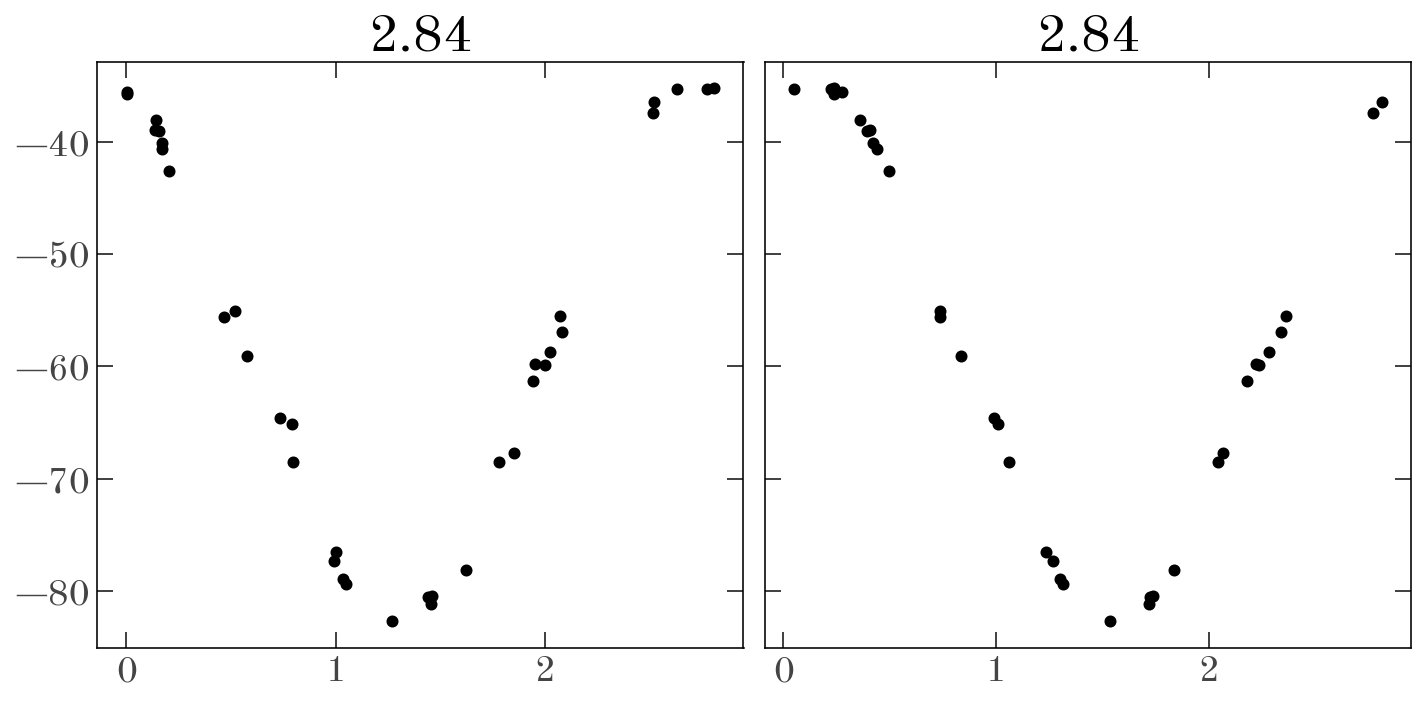

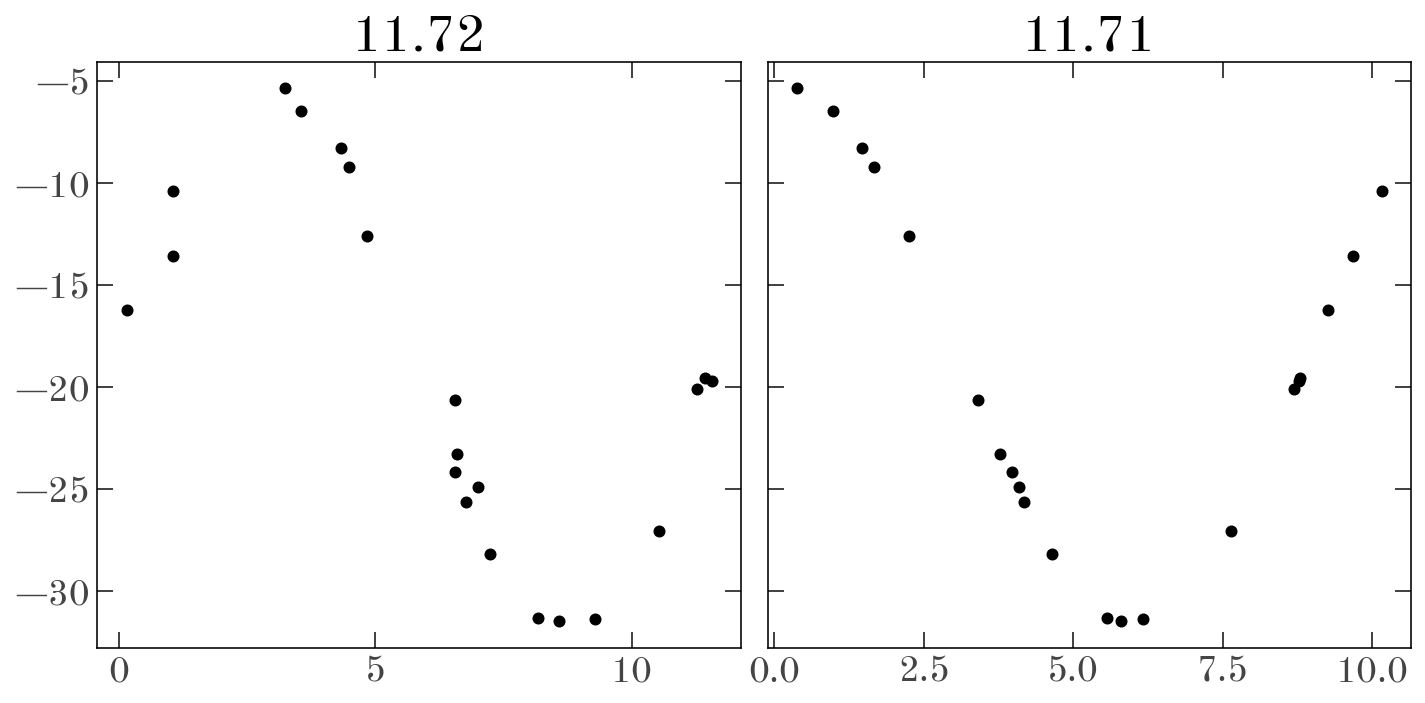

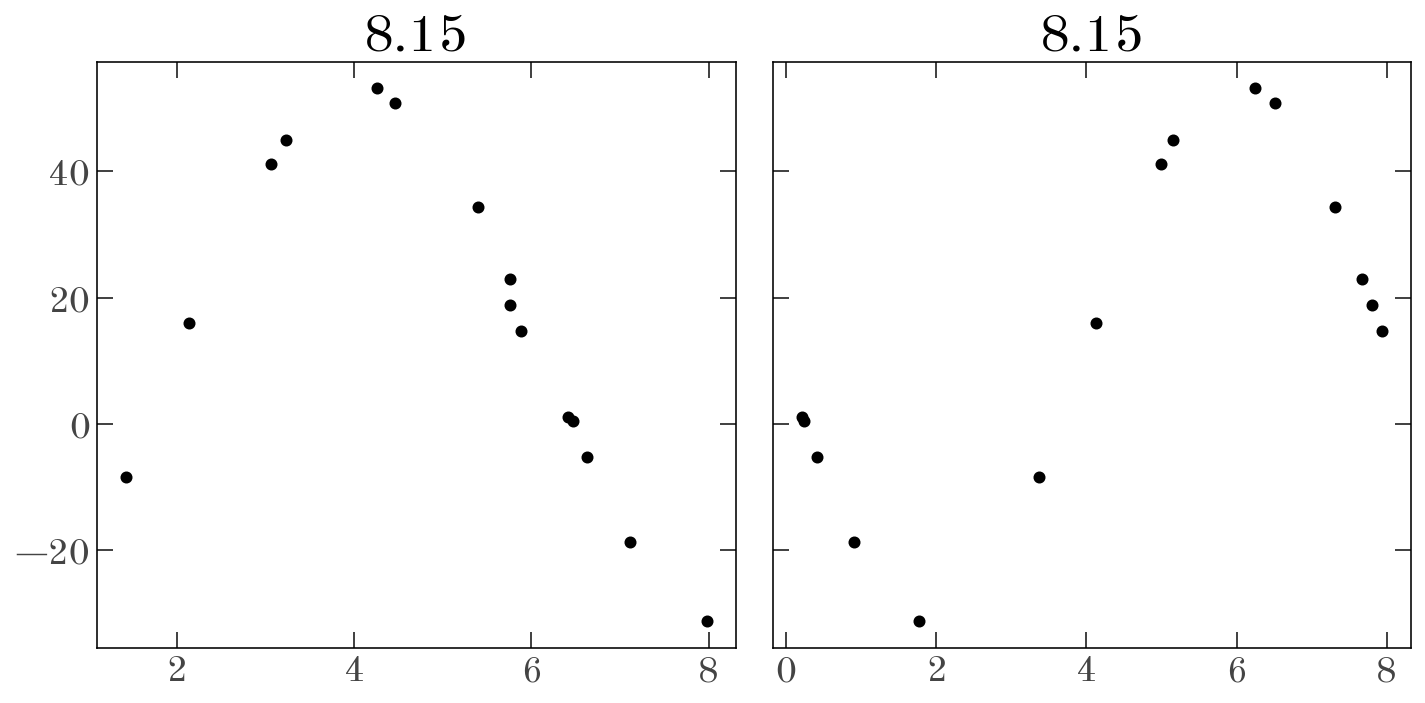

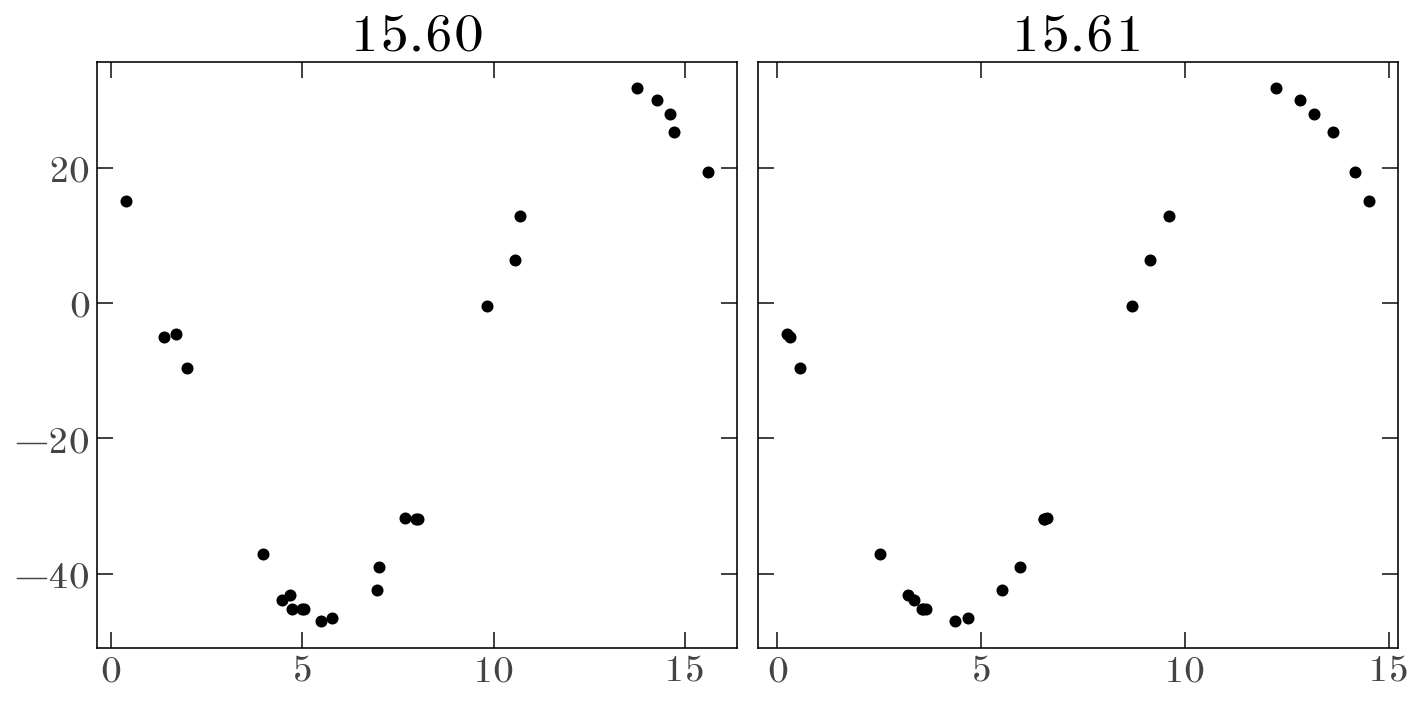

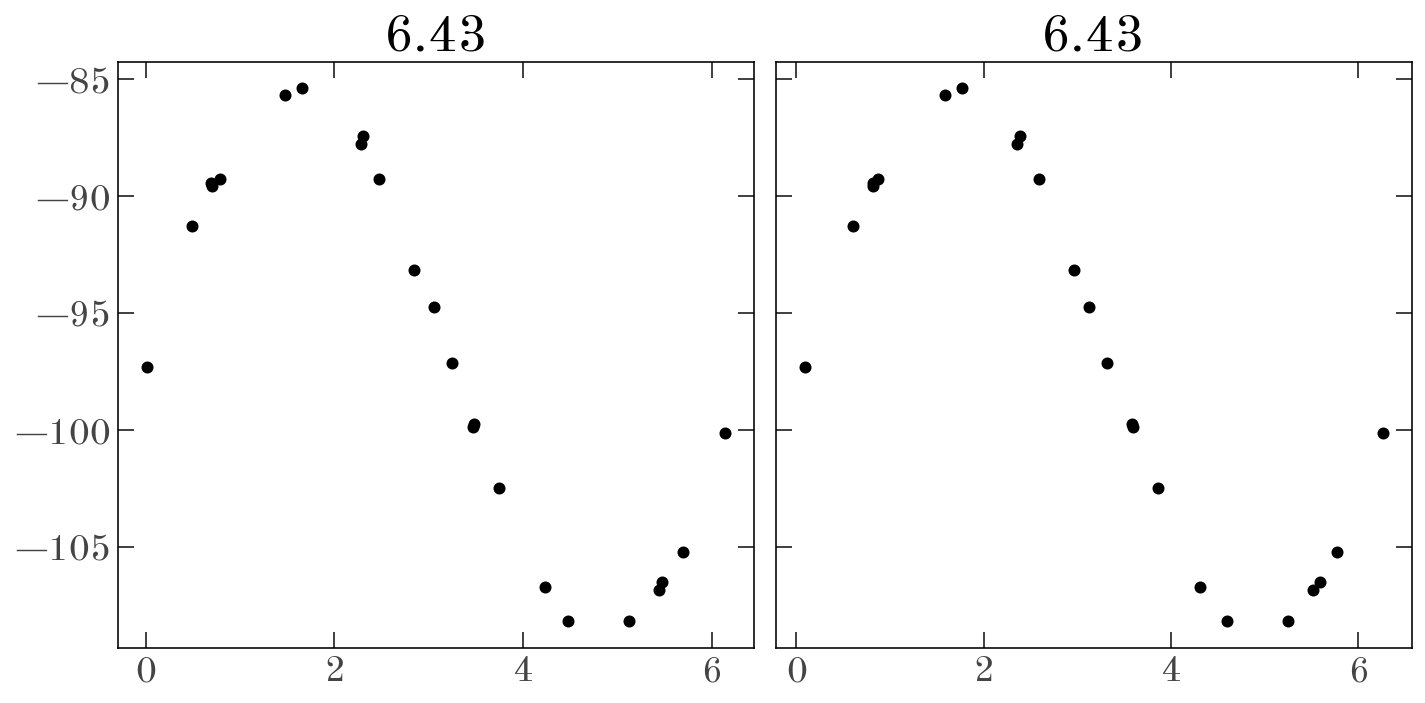

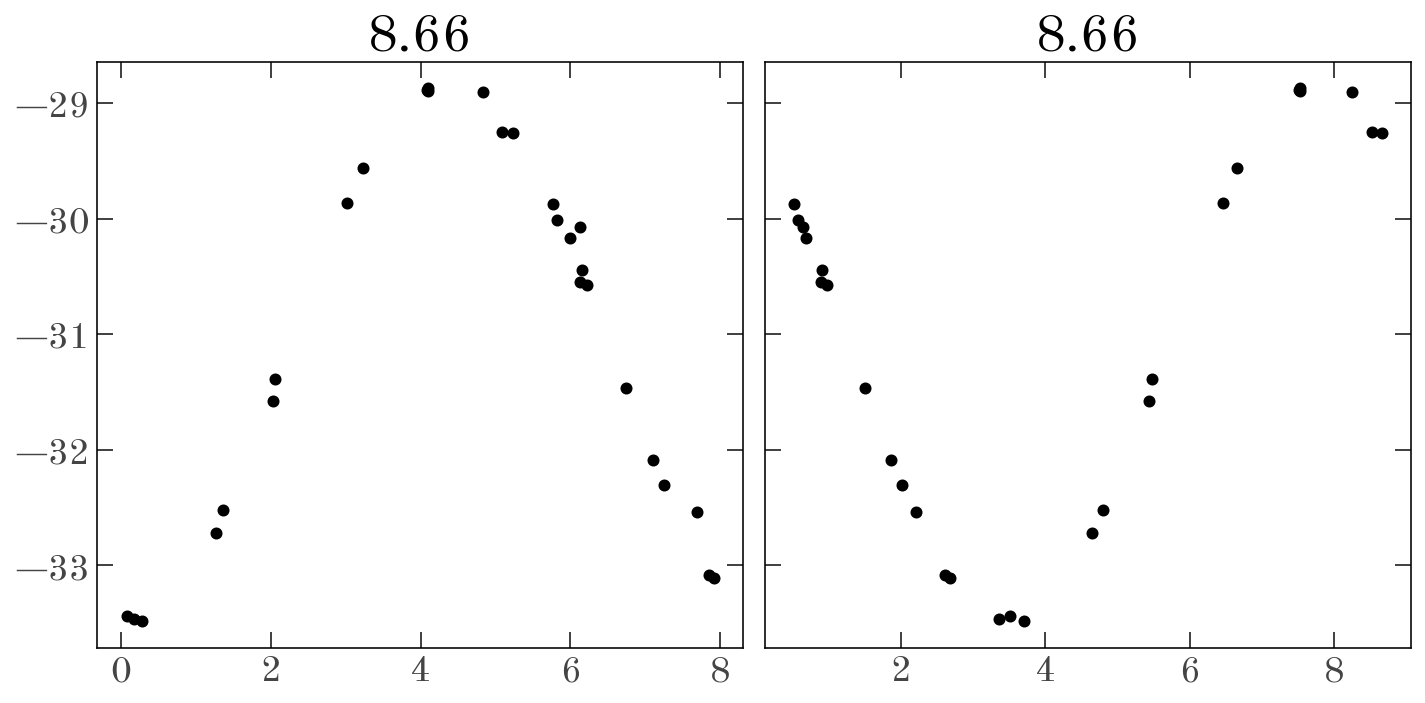

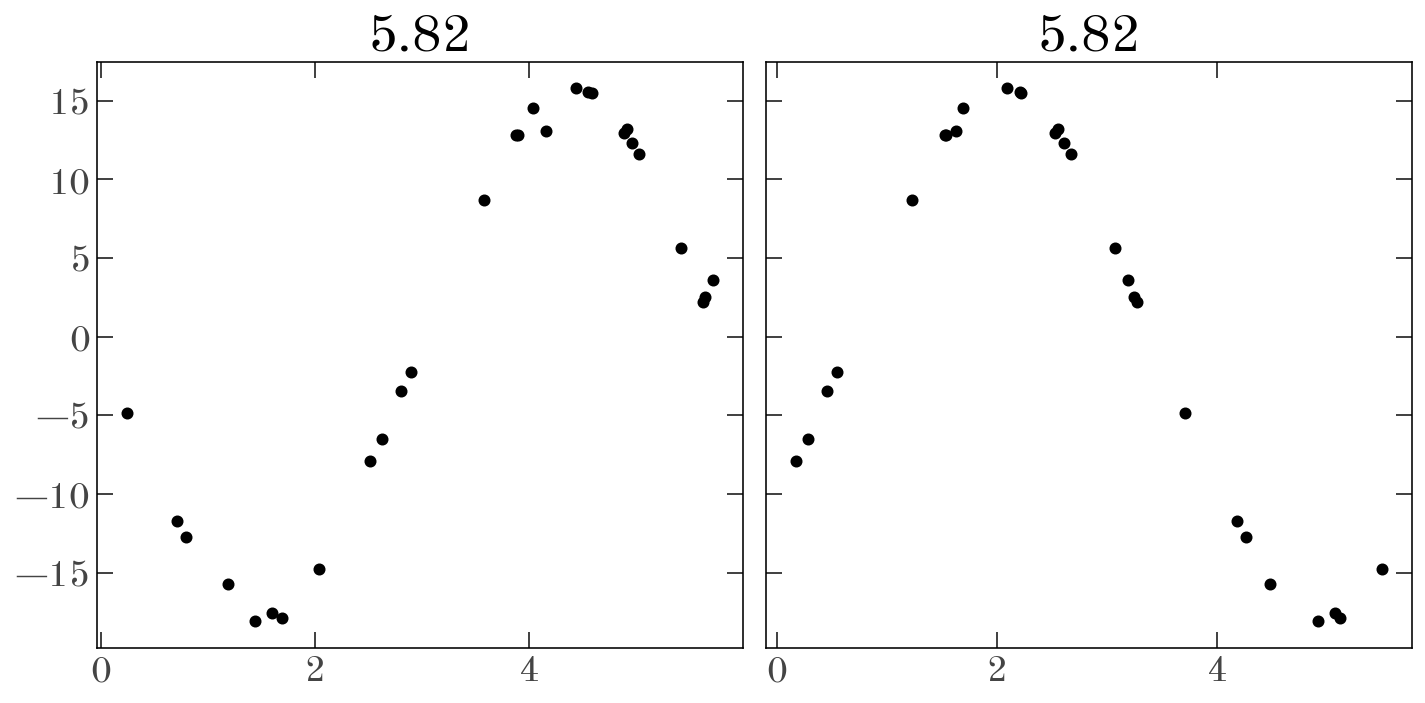

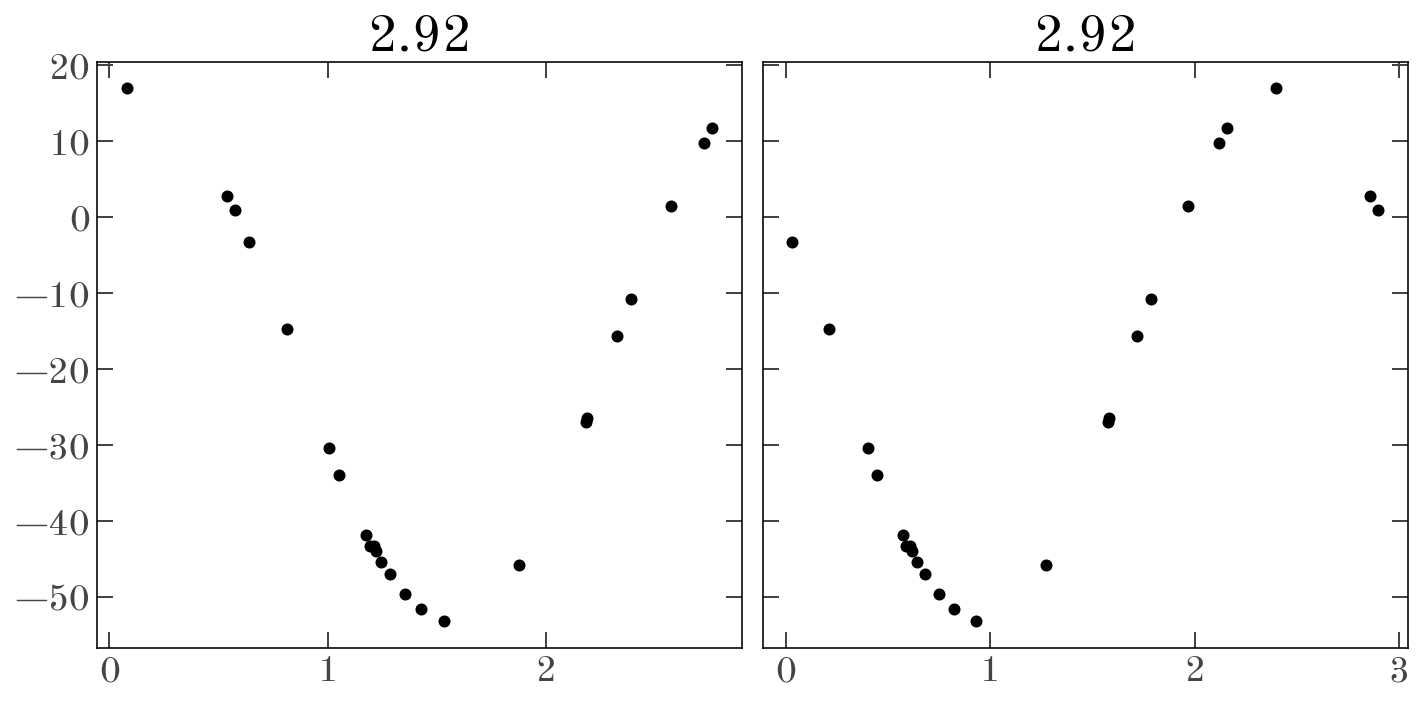

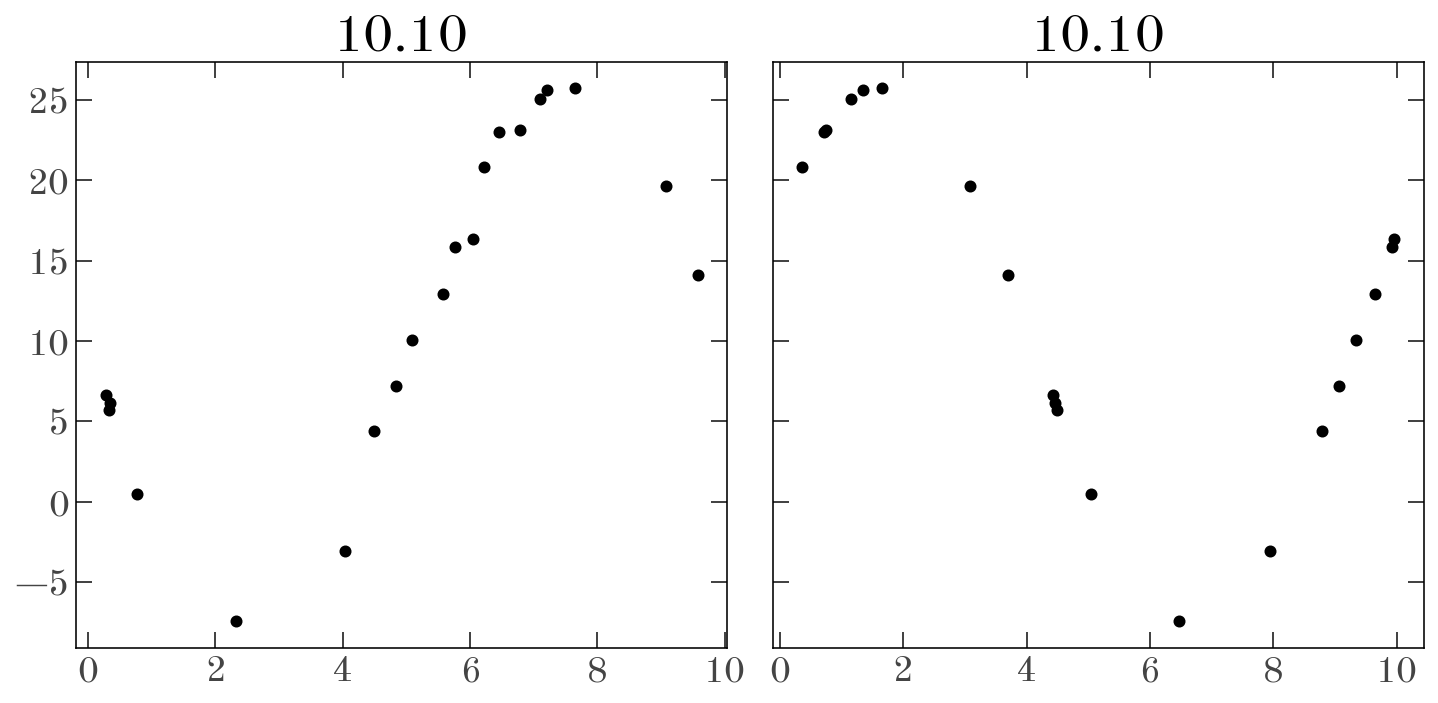

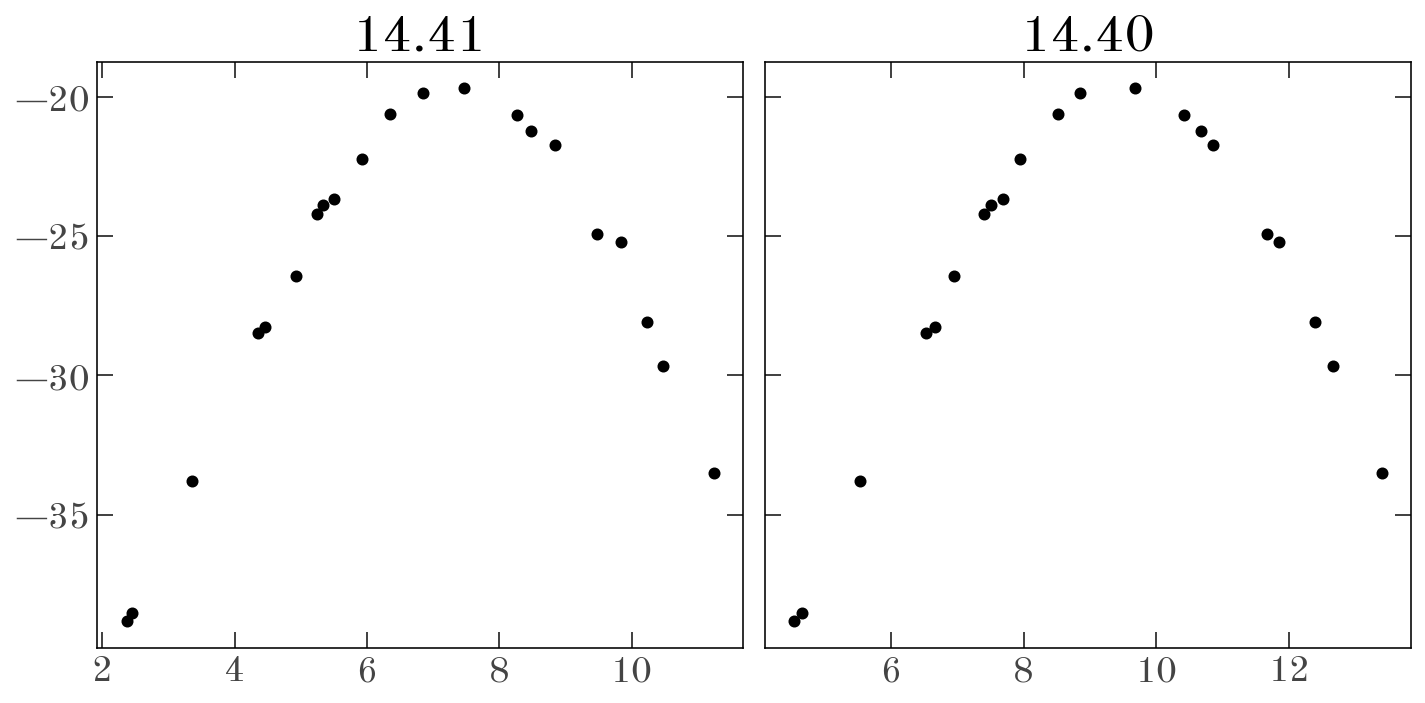

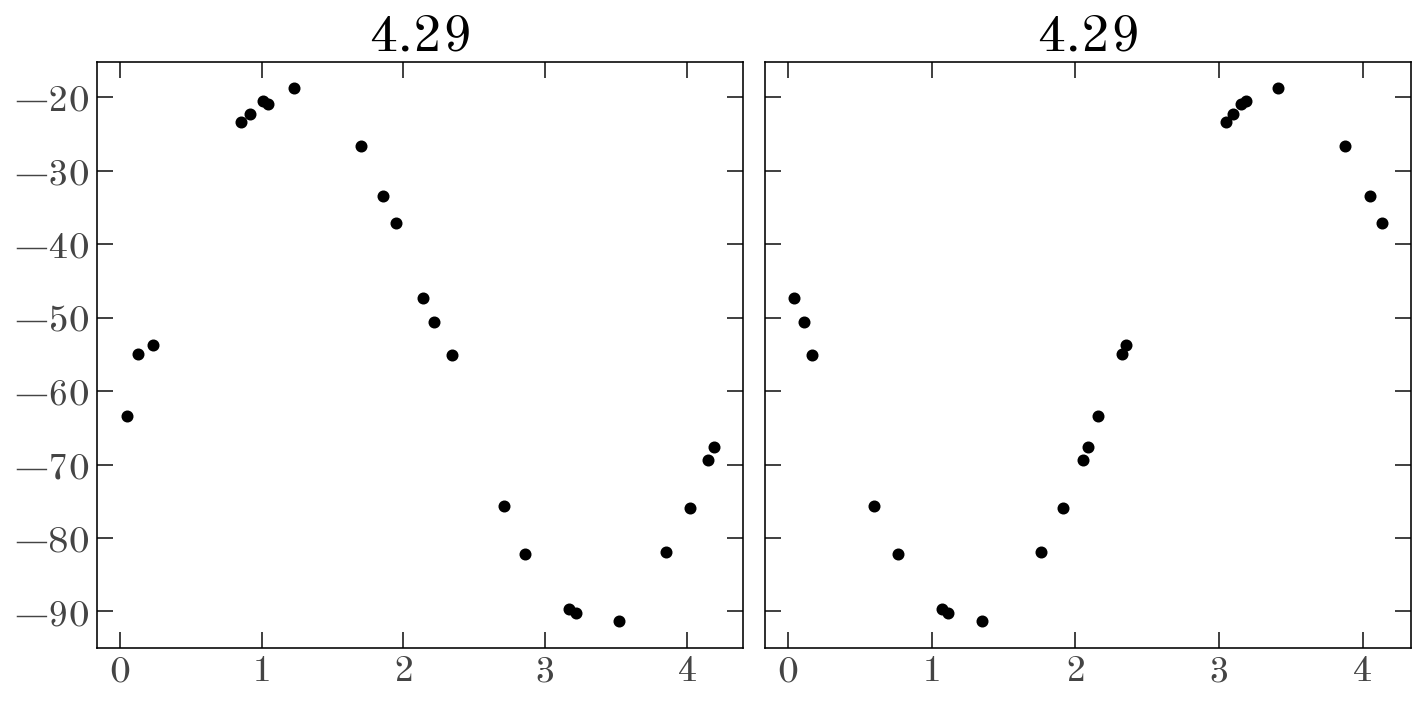

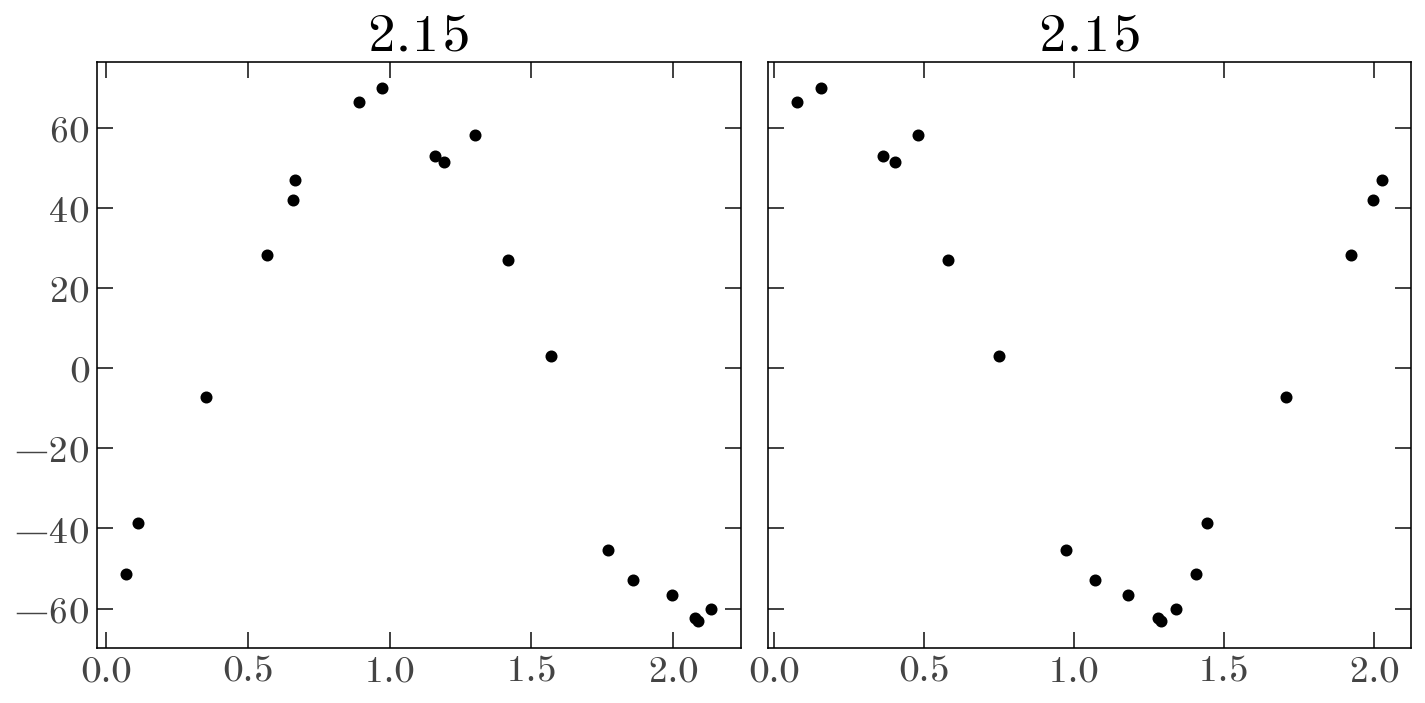

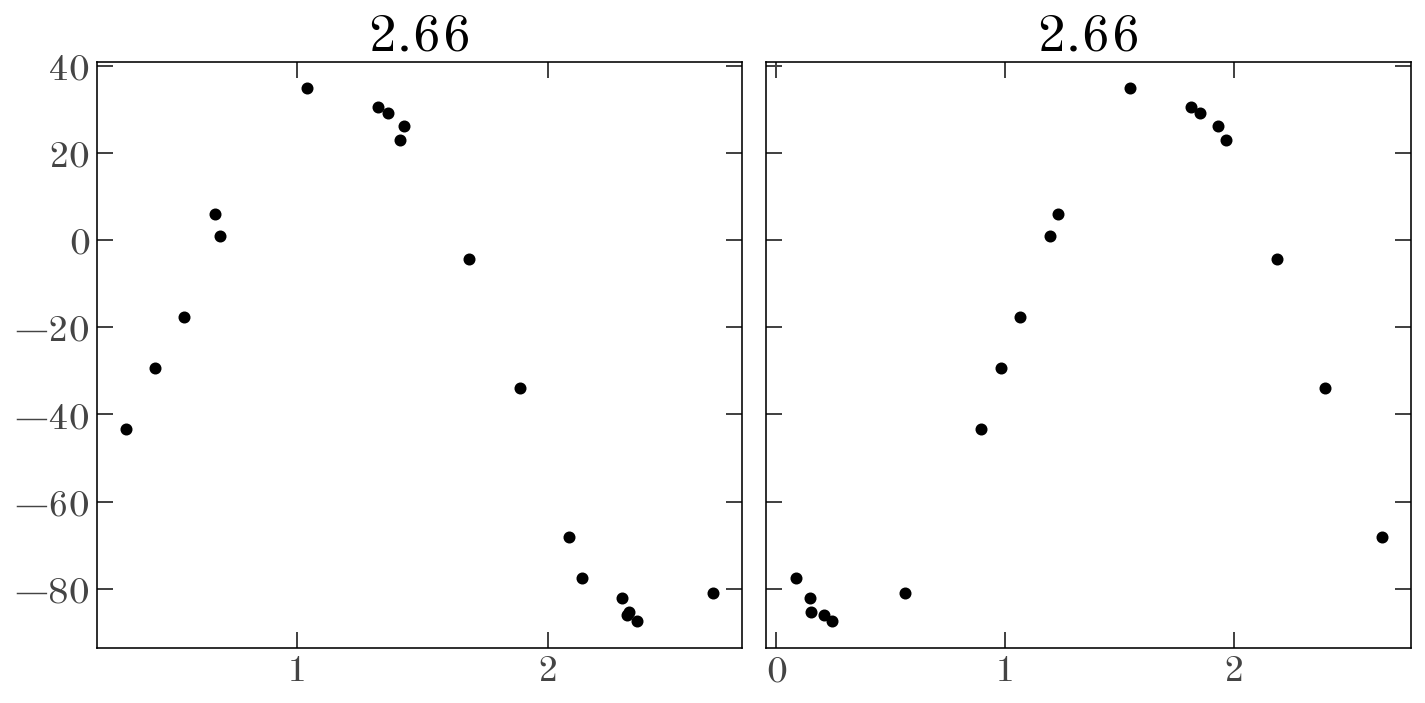

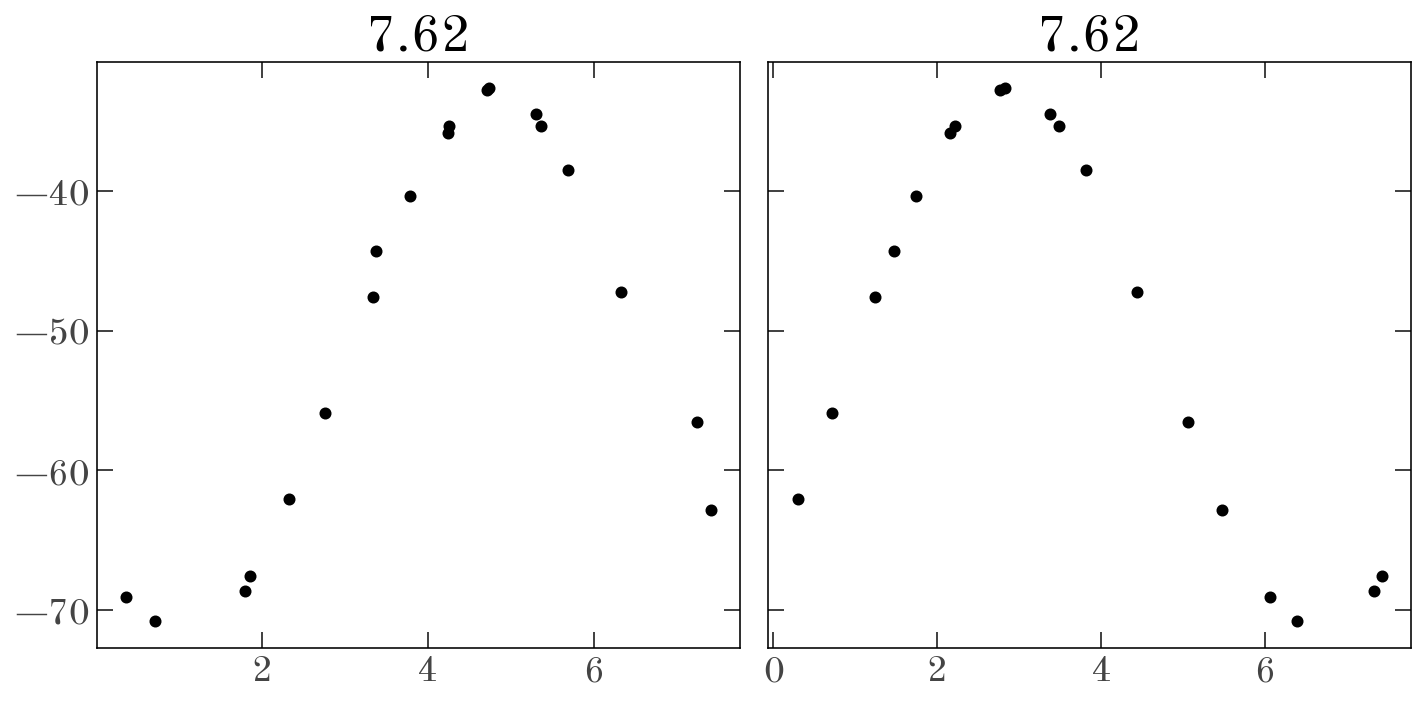

In [263]:
for apid in np.unique(all_visit_subsets['APOGEE_ID']):
    rows = all_visit_subsets[all_visit_subsets['APOGEE_ID'] == apid]
    ls = LombScargle(rows['JD'] * u.day, rows['VHELIO'], rows['VHELIO_ERR'])
    
    freq, power = ls.autopower(
        minimum_frequency=1/(20*u.day), 
        maximum_frequency=1/(1.5*u.day),
        samples_per_peak=10
    )
    
    P = 1 / freq[power.argmax()]
    
    MAP_P = binaries[binaries['APOGEE_ID'] == apid]['MAP_P'][0]
    print(P, MAP_P)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    axes[0].scatter(rows['JD'] % P.value, rows['VHELIO'])
    axes[0].set_title(f"{P.value:.2f}")
    axes[1].scatter(rows['JD'] % MAP_P.value, rows['VHELIO'])
    axes[1].set_title(f"{MAP_P.value:.2f}")
    fig.tight_layout()

# Gaia data:

In [13]:
cluster_c = coord.SkyCoord.from_name('NGC 6819')
cluster_c, cluster_c.galactic

(<SkyCoord (ICRS): (ra, dec) in deg
     (295.327, 40.19)>,
 <SkyCoord (Galactic): (l, b) in deg
     (73.98151852, 8.48109213)>)

In [44]:
radius = coord.Angle(5*u.arcmin * 4)

In [70]:
filename = pathlib.Path('NGC6819-gaiadr3.fits.gz')
columns = ['source_id',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'phot_g_mean_flux_over_error',
 'phot_g_mean_mag',
 'phot_bp_mean_flux_over_error',
 'phot_bp_mean_mag',
 'phot_rp_mean_flux_over_error',
 'phot_rp_mean_mag',
 'radial_velocity',
 'radial_velocity_error']

if not filename.exists() or True:
    q = f"""
SELECT {', '.join(columns)} FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(
   POINT({cluster_c.ra.degree}, {cluster_c.dec.degree}),
   CIRCLE(ra, dec, {radius.degree})) AND ruwe < 1.4
    """
    job = Gaia.launch_job_async(q)
    
    tbl = job.get_results()
    for col in tbl.colnames:
        if hasattr(tbl[col], 'mask') and tbl[col].mask.sum() == 0:
            tbl[col] = tbl[col].filled()
    tbl = tbl.filled(np.nan)
    
    data = at.QTable(tbl)
    data.write(filename, overwrite=True)

INFO: Query finished. [astroquery.utils.tap.core]


Image cutout:

In [46]:
query_results = Simbad.query_region(cluster_c)

In [47]:
object_main_id = query_results[0]['MAIN_ID']
object_main_id

'NGC  6819'

In [54]:
query_params = { 
    'hips': 'DSS', 
    'object': object_main_id, 
    'ra': cluster_c.ra.degree,
    'dec': cluster_c.dec.degree,
    'fov': (2 * radius).degree,
    'width': 1024, 
    'height': 1024 
}                                                                                               
url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?{urlencode(query_params)}' 
url

'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?hips=DSS&object=NGC++6819&ra=295.327&dec=40.19&fov=0.6666666666666666&width=1024&height=1024'

In [86]:
hdul = fits.open(url)
hdul.writeto('NGC6819-DSS-r.fits', overwrite=True)

In [78]:
from astropy.wcs import WCS
wcs = WCS(hdul[0].header)

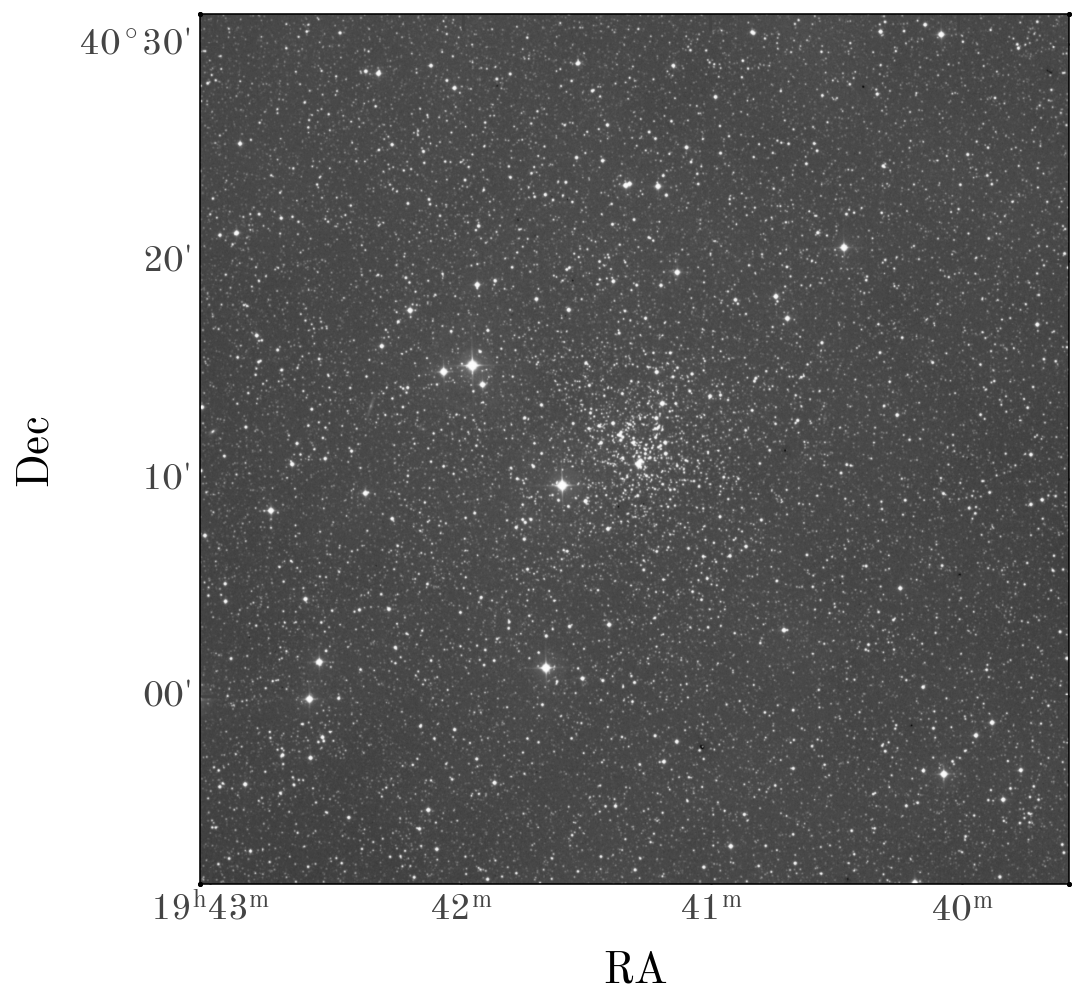

In [84]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=wcs))
ax.imshow(hdul[0].data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')